In [1]:
import torch
from glob import glob
import numpy as np
import utils
from matplotlib import pyplot as plt
import cv2
from torch.autograd import Variable

from torch.nn import functional as F

import utils

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)
from datasets import tub

In [2]:
import torch

backwarp_tenGrid = {}
backwarp_tenPartial = {}

def backwarp(tenInput, tenFlow):
	if str(tenFlow.size()) not in backwarp_tenGrid:
		tenHorizontal = torch.linspace(-1.0, 1.0, tenFlow.shape[3]).view(1, 1, 1, tenFlow.shape[3]).expand(tenFlow.shape[0], -1, tenFlow.shape[2], -1)
		tenVertical = torch.linspace(-1.0, 1.0, tenFlow.shape[2]).view(1, 1, tenFlow.shape[2], 1).expand(tenFlow.shape[0], -1, -1, tenFlow.shape[3])

		backwarp_tenGrid[str(tenFlow.size())] = torch.cat([ tenHorizontal, tenVertical ], 1).cuda()
	# end

	if str(tenFlow.size()) not in backwarp_tenPartial:
		backwarp_tenPartial[str(tenFlow.size())] = tenFlow.new_ones([ tenFlow.shape[0], 1, tenFlow.shape[2], tenFlow.shape[3] ])
	# end

	tenFlow = torch.cat([ tenFlow[:, 0:1, :, :] / ((tenInput.shape[3] - 1.0) / 2.0), tenFlow[:, 1:2, :, :] / ((tenInput.shape[2] - 1.0) / 2.0) ], 1)
	tenInput = torch.cat([ tenInput, backwarp_tenPartial[str(tenFlow.size())] ], 1)

	tenOutput = torch.nn.functional.grid_sample(input=tenInput, grid=(backwarp_tenGrid[str(tenFlow.size())] + tenFlow).permute(0, 2, 3, 1), mode='bilinear', padding_mode='zeros', align_corners=True)

	tenMask = tenOutput[:, -1:, :, :]; tenMask[tenMask > 0.999] = 1.0; tenMask[tenMask < 1.0] = 0.0

	return tenOutput[:, :-1, :, :] * tenMask
# end

In [3]:
def warp(x, flo):
    """
    warp an image/tensor (im2) back to im1, according to the optical flow

    x: [B, C, H, W] (im2)
    flo: [B, 2, H, W] flow

    """
    B, C, H, W = x.size()
    # mesh grid
    xx = torch.arange(0, W).view(1 ,-1).repeat(H ,1)
    yy = torch.arange(0, H).view(-1 ,1).repeat(1 ,W)
    xx = xx.view(1 ,1 ,H ,W).repeat(B ,1 ,1 ,1)
    yy = yy.view(1 ,1 ,H ,W).repeat(B ,1 ,1 ,1)
    grid = torch.cat((xx ,yy) ,1).float()

    if x.is_cuda:
        grid = grid.cuda()
    vgrid = Variable(grid) + flo

    # scale grid to [-1,1]
    vgrid[: ,0 ,: ,:] = 2.0 *vgrid[: ,0 ,: ,:].clone() / max( W -1 ,1 ) -1.0
    vgrid[: ,1 ,: ,:] = 2.0 *vgrid[: ,1 ,: ,:].clone() / max( H -1 ,1 ) -1.0

    vgrid = vgrid.permute(0 ,2 ,3 ,1)
    flo = flo.permute(0 ,2 ,3 ,1)
    output = F.grid_sample(x, vgrid)
    mask = torch.autograd.Variable(torch.ones(x.size())).cuda()
    mask = F.grid_sample(mask, vgrid)

    mask[mask <0.9999] = 0
    mask[mask >0] = 1

    return output*mask

results/flow_5.flo


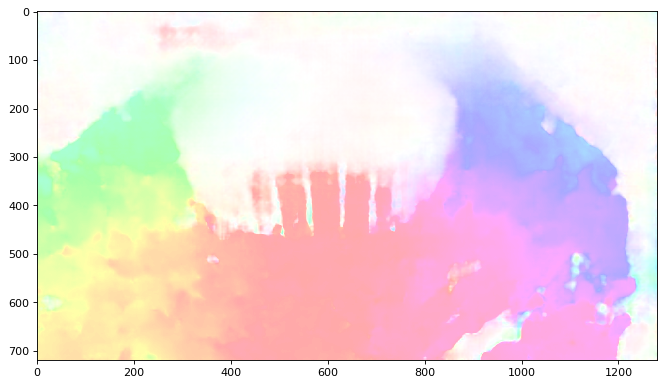

(720, 1280, 3) <class 'numpy.ndarray'> uint8


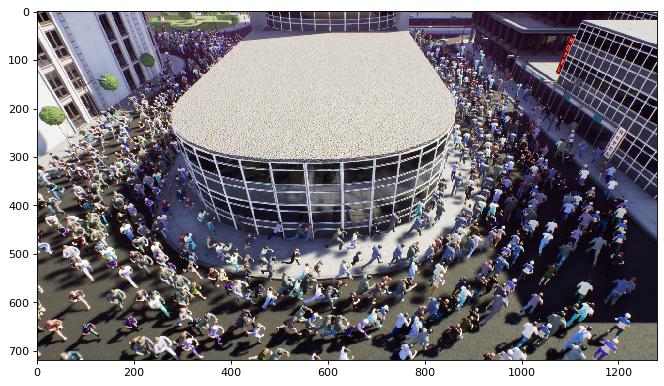

In [4]:
file = 'results/flow_5.flo'
index = 10

test_img2 = cv2.imread('frame_0011.png')
print(file)
f = open(file)
numbers = np.fromfile(f, dtype=np.uint8, count=4)
size = np.fromfile(f, dtype=np.int32, count=3)
numbers = np.fromfile(f, dtype=np.float32)
flows = numbers.reshape((size[0],size[2], size[1], 2))

videos = tub.load_all_videos('../data/TUBCrowdFlow', False)
frame_pairs = videos[0].get_frame_pairs()
frame_pairs = frame_pairs[index]


flow = flows[0]

plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
colors = utils.flo_to_color(flow)
plt.imshow(colors)
plt.show()

plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
image = cv2.imread(frame_pairs.get_frames(0).get_image_path())
print(image.shape, type(image), image.dtype)
s_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(s_image)
plt.show()

image = image[None, ...]
flow = flow[None, ...]

Backwarp: 14ms
14


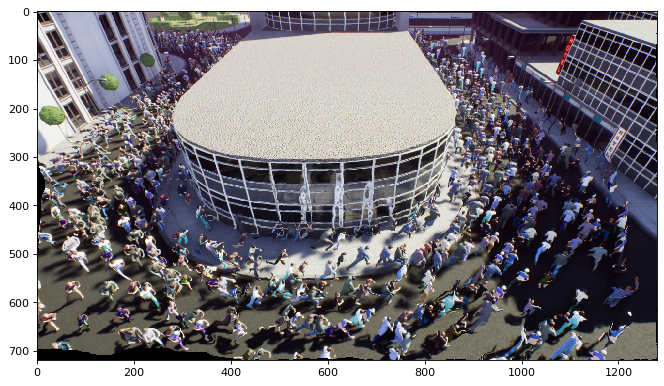

In [7]:
p_image = torch.from_numpy(image)
p_image = p_image.type(torch.float)
p_flow = torch.from_numpy(flow)

p_image = p_image.permute(0, 3, 1, 2)
p_flow = p_flow.permute(0, 3, 1, 2)

p_image = Variable(p_image).cuda()
p_flow = Variable(p_flow).cuda()

timer = utils.sTimer('Backwarp')
out = warp(p_image, p_flow*10)
out = out.permute(0, 2, 3, 1)

print(timer.show())

plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
warp_out = np.uint8(out.squeeze().cpu())
s2_image = cv2.cvtColor(warp_out, cv2.COLOR_BGR2RGB)
plt.imshow(s2_image)
plt.show()

Backwarp: 1ms
1


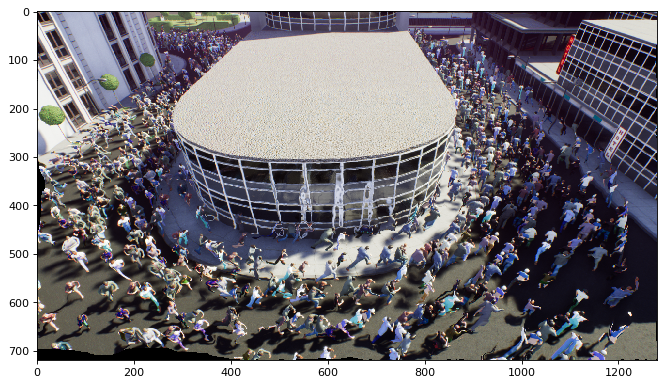

In [11]:
p_image = torch.from_numpy(image)
p_image = p_image.type(torch.float)
p_flow = torch.from_numpy(flow)

p_image = p_image.permute(0, 3, 1, 2)
p_flow = p_flow.permute(0, 3, 1, 2)

p_image = Variable(p_image).cuda()
p_flow = Variable(p_flow).cuda()

timer = utils.sTimer('Backwarp')
out = backwarp(p_image, p_flow*10)
out = out.permute(0, 2, 3, 1)

print(timer.show())

plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
warp_out = np.uint8(out.squeeze().cpu())
s2_image = cv2.cvtColor(warp_out, cv2.COLOR_BGR2RGB)
plt.imshow(s2_image)
plt.show()